# Data mining assignment 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as r
import lightgbm as lgb


from collections import Counter
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('training_set_vu_DM.csv')
df_test = pd.read_csv('test_set_vu_DM.csv')

In [3]:
train_vals = max(df.count().values)
test_vals = max(df_test.count().values)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Veel missing values, verwijder alle features met meer dan 10% NA's (kan evt nog meer NA's worden, maar dat wordt wel meer imputen)

In [5]:
null_values = df.isnull().sum()
to_keep = null_values.index[np.asarray(null_values/train_vals < 0.90)]
df_no_na = df[to_keep]

In [6]:
to_keep_test = [x for x in list(to_keep) if x not in ['position', 'click_bool', 'booking_bool']]
df_test2 = df_test[to_keep_test]

In [7]:
comp_rate = pd.Series(np.zeros(train_vals,))
comp_test_rate = pd.Series(np.zeros(test_vals,))
for x in range(1,9):
    temp_rate = np.where(df['comp'+str(x)+'_rate'].isnull(), 0, df['comp'+str(x)+'_rate'])
    comp_rate += temp_rate
    
    temp_test_rate = np.where(df_test['comp'+str(x)+'_rate'].isnull(), 0, df_test['comp'+str(x)+'_rate'])
    comp_test_rate += temp_test_rate
comp_rate = np.where(comp_rate < -1, -1, comp_rate)
comp_rate = pd.Series(np.where(comp_rate > 1, 1, comp_rate))

comp_test_rate = np.where(comp_test_rate < -1, -1, comp_test_rate)
comp_test_rate = pd.Series(np.where(comp_test_rate > 1, 1, comp_test_rate))

comp_inv = pd.Series(np.zeros(train_vals,))
comp_test_inv = pd.Series(np.zeros(test_vals,))
for x in range(1,9):
    temp_inv = np.where(df['comp'+str(x)+'_inv'].isnull(), 0, df['comp'+str(x)+'_inv'])
    comp_inv += temp_inv
    
    temp_test_inv = np.where(df_test['comp'+str(x)+'_inv'].isnull(), 0, df_test['comp'+str(x)+'_inv'])
    comp_test_inv += temp_test_inv
    

df_no_na['comp_rate'] = comp_rate
df_no_na['comp_inv'] = comp_inv

df_test2['comp_rate'] = comp_test_rate
df_test2['comp_inv'] = comp_test_inv
df_no_na2 = df_no_na.drop(['comp2_rate', 'comp3_rate', 'comp5_rate', 'comp8_rate',
                           'comp2_inv', 'comp3_inv', 'comp5_inv', 'comp8_inv',
                          'comp5_rate_percent_diff', 'comp8_rate_percent_diff', 'comp2_rate_percent_diff'], axis=1)
df_test3 = df_test2.drop(['comp2_rate', 'comp3_rate', 'comp5_rate', 'comp8_rate',
                           'comp2_inv', 'comp3_inv', 'comp5_inv', 'comp8_inv',
                          'comp5_rate_percent_diff', 'comp8_rate_percent_diff', 'comp2_rate_percent_diff'], axis=1)
df_test3.isnull().sum()

/Users/robinschijf/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/robinschijf/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/robinschijf/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7266
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1088032
prop_log_historical_price            0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
orig_destination_distance      1608679
random_bool                          0
comp_rate                            0
comp_inv                             0
dtype: int64

Prop_review_score en Prop_location_score2 hebben nog NA's dus die moeten we imputen. Heb ze nu allebei ge-impute aan de hand van hun distributie, maar we kunnen misschien ook nog prop_location_score2 imputen adhv de andere location score maar weet niet echt goed hoe

In [8]:
probs = df_no_na2['prop_review_score'].value_counts(normalize=True)
isnull = df_no_na2['prop_review_score'].isnull()
np.random.seed(15)
df_no_na2.loc[isnull, 'prop_review_score'] = np.random.choice(probs.index, size=len(df[isnull]), p=probs.values)

probs = df_test3['prop_review_score'].value_counts(normalize=True)
isnull = df_test3['prop_review_score'].isnull()
np.random.seed(15)
df_test3.loc[isnull, 'prop_review_score'] = np.random.choice(probs.index, size=len(df_test[isnull]), p=probs.values)



In [10]:
df_no_na2['prop_location_score2'] = df['prop_location_score2']

probs = df_no_na2['prop_location_score2'].value_counts(normalize=True)
isnull = df_no_na2['prop_location_score2'].isnull()
np.random.seed(15)
df_no_na2.loc[isnull, 'prop_location_score2'] = np.random.choice(probs.index, size=len(df[isnull]), p=probs.values)

df_test3['prop_location_score2'] = df_test['prop_location_score2']

probs = df_test3['prop_location_score2'].value_counts(normalize=True)
isnull = df_test3['prop_location_score2'].isnull()
np.random.seed(15)
df_test3.loc[isnull, 'prop_location_score2'] = np.random.choice(probs.index, size=len(df_test[isnull]), p=probs.values)

In [11]:
df_no_na2 = df_no_na2.drop(['orig_destination_distance'], axis=1)
df_test3 = df_test3.drop(['orig_destination_distance'], axis=1)

In [12]:
df_no_na2 = df_no_na2.drop(['date_time'], axis=1)
df_test3 = df_test3.drop(['date_time'], axis=1)


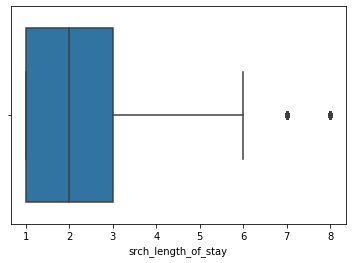

In [53]:
#Outliers verwijderen!
std = df_no_na2['srch_length_of_stay'].std()
mean = df_no_na2['srch_length_of_stay'].mean()
cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off
trimmed_df = df_no_na2[(df_no_na2['srch_length_of_stay'] < upper) \
                           & (df_no_na2['srch_length_of_stay'] > lower)]
sns.boxplot(x=trimmed_df['srch_length_of_stay'])

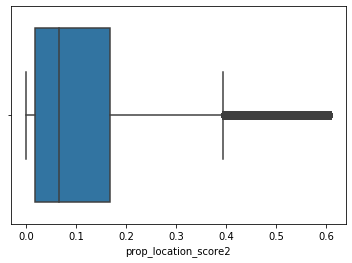

In [54]:
std = trimmed_df['prop_location_score2'].std()
mean = trimmed_df['prop_location_score2'].mean()

cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off

trimmed_df1 = trimmed_df[(trimmed_df['prop_location_score2'] < upper) \
                           & (trimmed_df['prop_location_score2'] > lower)]

sns.boxplot(x=trimmed_df1['prop_location_score2'])

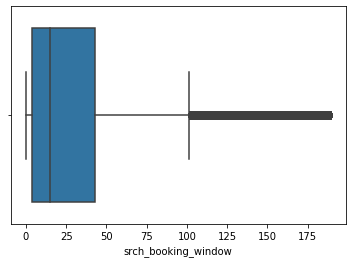

In [55]:
std = trimmed_df1['srch_booking_window'].std()
mean = trimmed_df1['srch_booking_window'].mean()

cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off

trimmed_df2 = trimmed_df1[(trimmed_df1['srch_booking_window'] < upper) \
                           & (trimmed_df1['srch_booking_window'] > lower)]

sns.boxplot(x=trimmed_df2['srch_booking_window'])

In [57]:
q_low = trimmed_df2["price_usd"].quantile(0.001)
q_hi  = trimmed_df2["price_usd"].quantile(0.999)

trimmed_df3 = trimmed_df2[(trimmed_df2["price_usd"] < q_hi) & (trimmed_df2["price_usd"] > q_low)]

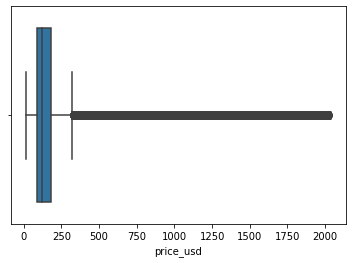

In [58]:
sns.boxplot(x=trimmed_df3['price_usd'])

In [59]:
trimmed_df3.describe()

,srch_id,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,random_bool,click_bool,booking_bool,comp_rate,comp_inv
count,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000,4639697.000
mean,166505.613,9.773,176.388,175.275,70136.759,3.170,3.780,0.644,2.830,0.117,4.301,16.947,151.299,0.214,14020.942,2.190,31.422,1.969,0.350,1.110,0.513,0.287,0.044,0.028,0.037,0.084
std,96126.246,7.519,65.390,67.499,40604.329,1.048,1.042,0.479,1.507,0.132,1.838,10.421,112.440,0.410,8105.927,1.517,39.184,0.856,0.733,0.416,0.500,0.452,0.205,0.164,0.500,0.442
min,1.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,14.200,0.000,2.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,-1.000,-6.000
25%,83054.000,5.000,100.000,100.000,35048.000,3.000,3.500,0.000,1.790,0.018,4.440,8.000,85.000,0.000,7100.000,1.000,4.000,2.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,166702.000,5.000,219.000,219.000,69688.000,3.000,4.000,1.000,2.770,0.066,4.900,16.000,120.000,0.000,13539.000,2.000,15.000,2.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000
75%,249934.000,14.000,219.000,219.000,105245.000,4.000,4.500,1.000,3.970,0.169,5.300,26.000,180.030,0.000,21055.000,3.000,43.000,2.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000
max,332785.000,34.000,231.000,230.000,140821.000,5.000,5.000,1.000,6.980,0.609,6.210,40.000,2034.640,1.000,28416.000,8.000,189.000,9.000,9.000,8.000,1.000,1.000,1.000,1.000,1.000,6.000
